<H1>Countries Attending UN Delegates General Assembly with their Topics and Similarities From 2009 - 2019</H1>
<author>Charita Ramnathsing</author>

In this kernel I attempt to determine engagement between countries based on the similarity of words they use in UN General Debates speeches over five year periods. 

In [1]:
# import modules
import pandas as pd
import numpy as np
import pycountry
import re
import tqdm
import matplotlib.pyplot as plt

# load data
data = pd.read_csv('un-general-assembly-debates.csv')

In [2]:
import nltk, spacy, gensim # Sklearn
from sklearn.feature_extraction.text import CountVectorizer
from pprint import pprint # Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
%matplotlib inline

In [3]:
# peak into data
data = pd.read_csv('un-general-assembly-debates.csv')
data.head()

,session,year,country,text
0,44,1989,MDV,﻿It is indeed a pleasure for me and the member...
1,44,1989,FIN,"﻿\nMay I begin by congratulating you. Sir, on ..."
2,44,1989,NER,"﻿\nMr. President, it is a particular pleasure ..."
3,44,1989,URY,﻿\nDuring the debate at the fortieth session o...
4,44,1989,ZWE,﻿I should like at the outset to express my del...


In [4]:
df = data.dropna(subset=['text'])
df

,session,year,country,text
0,44,1989,MDV,﻿It is indeed a pleasure for me and the member...
1,44,1989,FIN,"﻿\nMay I begin by congratulating you. Sir, on ..."
2,44,1989,NER,"﻿\nMr. President, it is a particular pleasure ..."
3,44,1989,URY,﻿\nDuring the debate at the fortieth session o...
4,44,1989,ZWE,﻿I should like at the outset to express my del...
...,...,...,...,...
7502,56,2001,KAZ,﻿This session\nthat is taking place under extr...
7503,56,2001,LBR,﻿I am honoured to\nparticipate in this histori...
7504,56,2001,BDI,﻿It\nis for me a signal honour to take the flo...
7505,56,2001,HUN,"﻿First, may I congratulate Mr. Han Seung-soo o..."


In [5]:
# convert text data to lower case (for easier analysis)
df['text'] = df['text'].str.lower()

In [6]:
# Remove unusual symbols from description
def clean(s):    
    # Remove any tags:
    cleaned = re.sub(r"(?s)<.?>", " ", s)
    # Keep only regular chars:
    cleaned = re.sub(r"[^A-Za-z0-9(),*!?\'\`]", " ", cleaned)
    # Remove unicode chars
    cleaned = re.sub("\\\\u(.){4}", " ", cleaned)
    return cleaned.strip()

# clean text
df['text'] = df.text.apply(lambda x: clean(x))

In [7]:
import pycountry
# change country code to country name
country_name = []
for code in data['country']:
    try:
        country_name.append(pycountry.countries.lookup(code).name)
    except LookupError:
        country_name.append('')
data['country_name'] = country_name

# add column for full country name
df.country = country_name

In [8]:
# remove data with null value in year column
df_notnull = df[df['year'].notnull()]

# drop session column -- provides no information
df_new = df_notnull.drop(['session', 'year', 'country'], axis=1)

In [9]:
stop_words = nltk.corpus.stopwords.words('english')
wtk = nltk.tokenize.RegexpTokenizer(r'\w+')
wnl = nltk.stem.wordnet.WordNetLemmatizer()

In [10]:
def normalize_corpus(words_cleaned):
    norm_words=[]
    for word in tqdm.tqdm(words_cleaned):
        word = word.lower()
        tokens = [token.strip() for token in wtk.tokenize(word)]
        tokens = [wnl.lemmatize(token) for token in tokens if not token.isnumeric()]
        tokens = [token for token in tokens if len(token) > 1]
        tokens = [token for token in tokens if token not in stop_words]
        tokens = list(filter(None, tokens))
        if tokens:
            norm_words.append(tokens)
    return norm_words

In [11]:
norm_words = normalize_corpus(df_new.text)

100%|██████████| 7507/7507 [02:19<00:00, 53.84it/s]


In [12]:
#higher threshold, fewer phrases
bigram = gensim.models.Phrases(norm_words, min_count=8, threshold=20, delimiter=b'_')
bigram_model = gensim.models.phrases.Phraser(bigram)

In [13]:
#bigrams words per doc/transcript: 'well_deserved' , 'sincere_congratulation', etc
data_corpus_bigram = [bigram_model[doc] for doc in norm_words]

In [14]:
# Create a dictionary representation of the documents
dictionary = gensim.corpora.Dictionary(data_corpus_bigram)

In [15]:
dictionary.filter_extremes(no_below=10, no_above=0.6)

In [16]:
#Transform corpus into bag of words vectors
bow_corpus = [dictionary.doc2bow(text) for text in data_corpus_bigram]

In [17]:
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.wrappers import LdaMallet
from gensim.models import CoherenceModel
import os

In [18]:
os.environ.update({'MALLET_HOME':r'my_folder/mallet-2.0.8/bin'})
MALLET_PATH = 'my_folder/mallet-2.0.8/bin/mallet'

In [19]:
lda_mallet = gensim.models.wrappers.LdaMallet(mallet_path=MALLET_PATH, corpus=bow_corpus, id2word=dictionary,
                                              num_topics=8,
                                              iterations=500, workers=4)

In [20]:
topics = [[(term, round(wt,3))
              for term, wt in lda_mallet.show_topic(n, topn=10)]
                     for n in range(0, lda_mallet.num_topics)]

In [21]:
tm_results = lda_mallet[bow_corpus]

In [22]:
corpus_topics = [sorted(topics_local, key=lambda record: -record[1])[0]
                        for topics_local in tm_results]

In [23]:
topics_df = pd.DataFrame([','.join([term for term, wt in topic])
                             for topic in topics],
                        columns = ['Terms per Topic'],
                        index=['Topic'+str(t) for t in range(1, lda_mallet.num_topics+1)])

In [24]:
corpus_topic_df = pd.DataFrame()
corpus_topic_df['Document'] = range(0, len(df.text))
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Description'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df['Country'] = df.country

In [25]:
pd.set_option('display.max_colwidth', 250)
corpus_topic_df.groupby('Dominant Topic').apply(lambda topic_set: (topic_set.sort_values(by=['Contribution %'],
                                                                                        ascending=False)
                                                                  .iloc[0]))

,Document,Dominant Topic,Contribution %,Topic Description,Country
Dominant Topic,,,,,
1,5522,1,61.54,"terrorism,iraq,palestinian,law,afghanistan,israel,comprehensive,council,humanitarian,party",United Arab Emirates
2,199,2,79.67,"israel,struggle,aggression,arab,military,independence,republic,territory,palestinian,viet_nam",Albania
3,6830,3,75.43,"law,solidarity,society,trade,justice,mankind,latin_america,reason,case,freedom",Nicaragua
4,3925,4,50.82,"small,change,past,million,le,doe,face,history,good,matter",Vanuatu
5,4137,5,64.36,"africa,democracy,african,republic,democratic,election,solidarity,continent,child,programme",Rwanda
6,5933,6,61.52,"south_africa,delegation,african,co_operation,namibia,independence,south,africa,apartheid,developed",Rwanda
7,231,7,74.93,"reform,agenda,sustainable_development,climate_change,millennium,trade,address,programme,financial,council",Tonga
8,2118,8,68.33,"disarmament,nuclear,europe,nuclear_weapon,proposal,european,co_operation,treaty,field,basis",Hungary


In [26]:
corpus_topic_df.set_index(['Document'])

,Dominant Topic,Contribution %,Topic Description,Country
Document,,,,
0,6,30.28,"south_africa,delegation,african,co_operation,namibia,independence,south,africa,apartheid,developed",Maldives
1,8,47.47,"disarmament,nuclear,europe,nuclear_weapon,proposal,european,co_operation,treaty,field,basis",Finland
2,6,31.14,"south_africa,delegation,african,co_operation,namibia,independence,south,africa,apartheid,developed",Niger
3,3,41.61,"law,solidarity,society,trade,justice,mankind,latin_america,reason,case,freedom",Uruguay
4,6,33.52,"south_africa,delegation,african,co_operation,namibia,independence,south,africa,apartheid,developed",Zimbabwe
...,...,...,...,...
7502,8,29.42,"disarmament,nuclear,europe,nuclear_weapon,proposal,european,co_operation,treaty,field,basis",Kazakhstan
7503,5,25.45,"africa,democracy,african,republic,democratic,election,solidarity,continent,child,programme",Liberia
7504,5,38.48,"africa,democracy,african,republic,democratic,election,solidarity,continent,child,programme",Burundi


In [33]:
topic_names = ['1. Humanitarian and Disaster Relief',
               '2. International Peace and Security',
               '3. Justice and International Law',
               '4. Organizational, Administration and Others',
               '5. Human Rights ',
               '6. Development of Africa',
               '7. Economic Growth and Sustainable Development',
               '8. Disarmament',
               ]

In [28]:
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS 

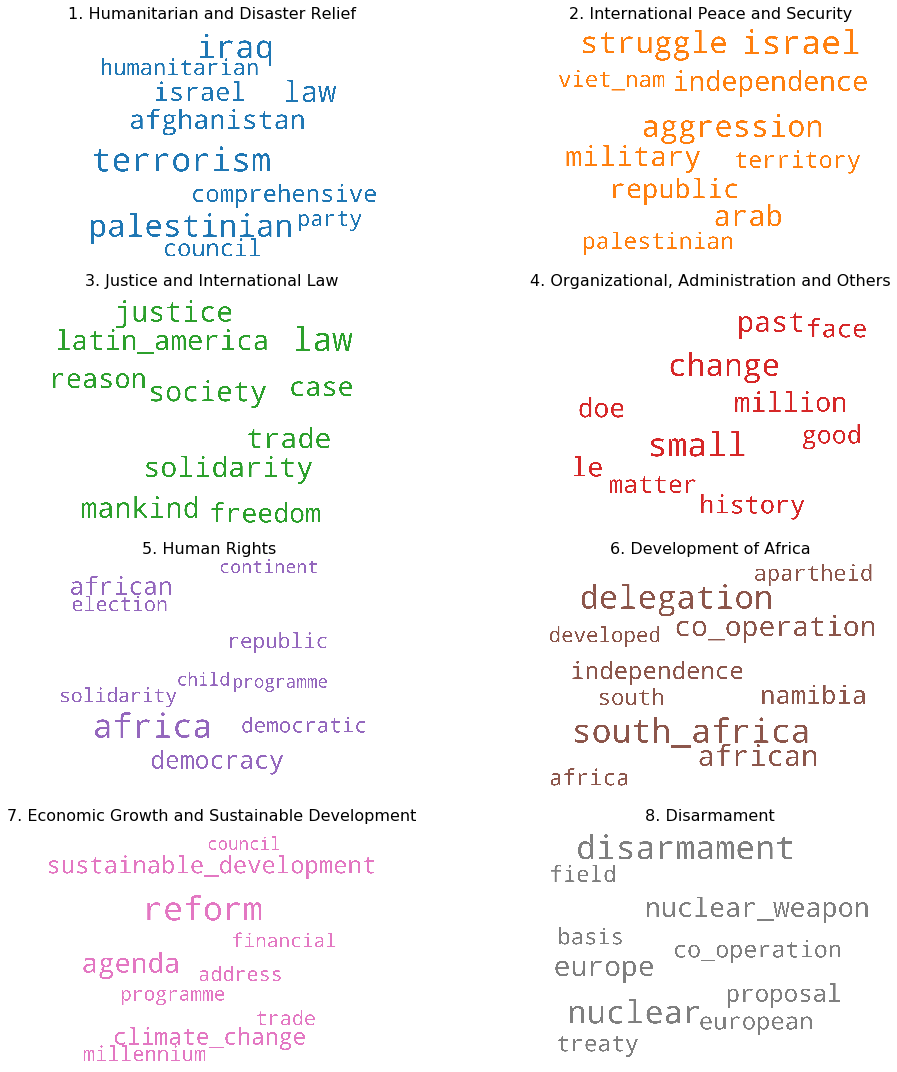

In [36]:
cols2 = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'
cloud2 = WordCloud(stopwords=gensim.parsing.preprocessing.STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols2[i],
                  prefer_horizontal=1.0)

topics = lda_mallet.show_topics(formatted=False)

fig2, axes2 = plt.subplots(4, 2, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes2.flatten()):
    name = topic_names[i]
    fig2.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud2.generate_from_frequencies(topic_words, max_font_size=250)
    plt.title('{}'.format(name), fontdict=dict(size=16))
    plt.imshow(cloud2)    
    plt.axis('off')
    
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()


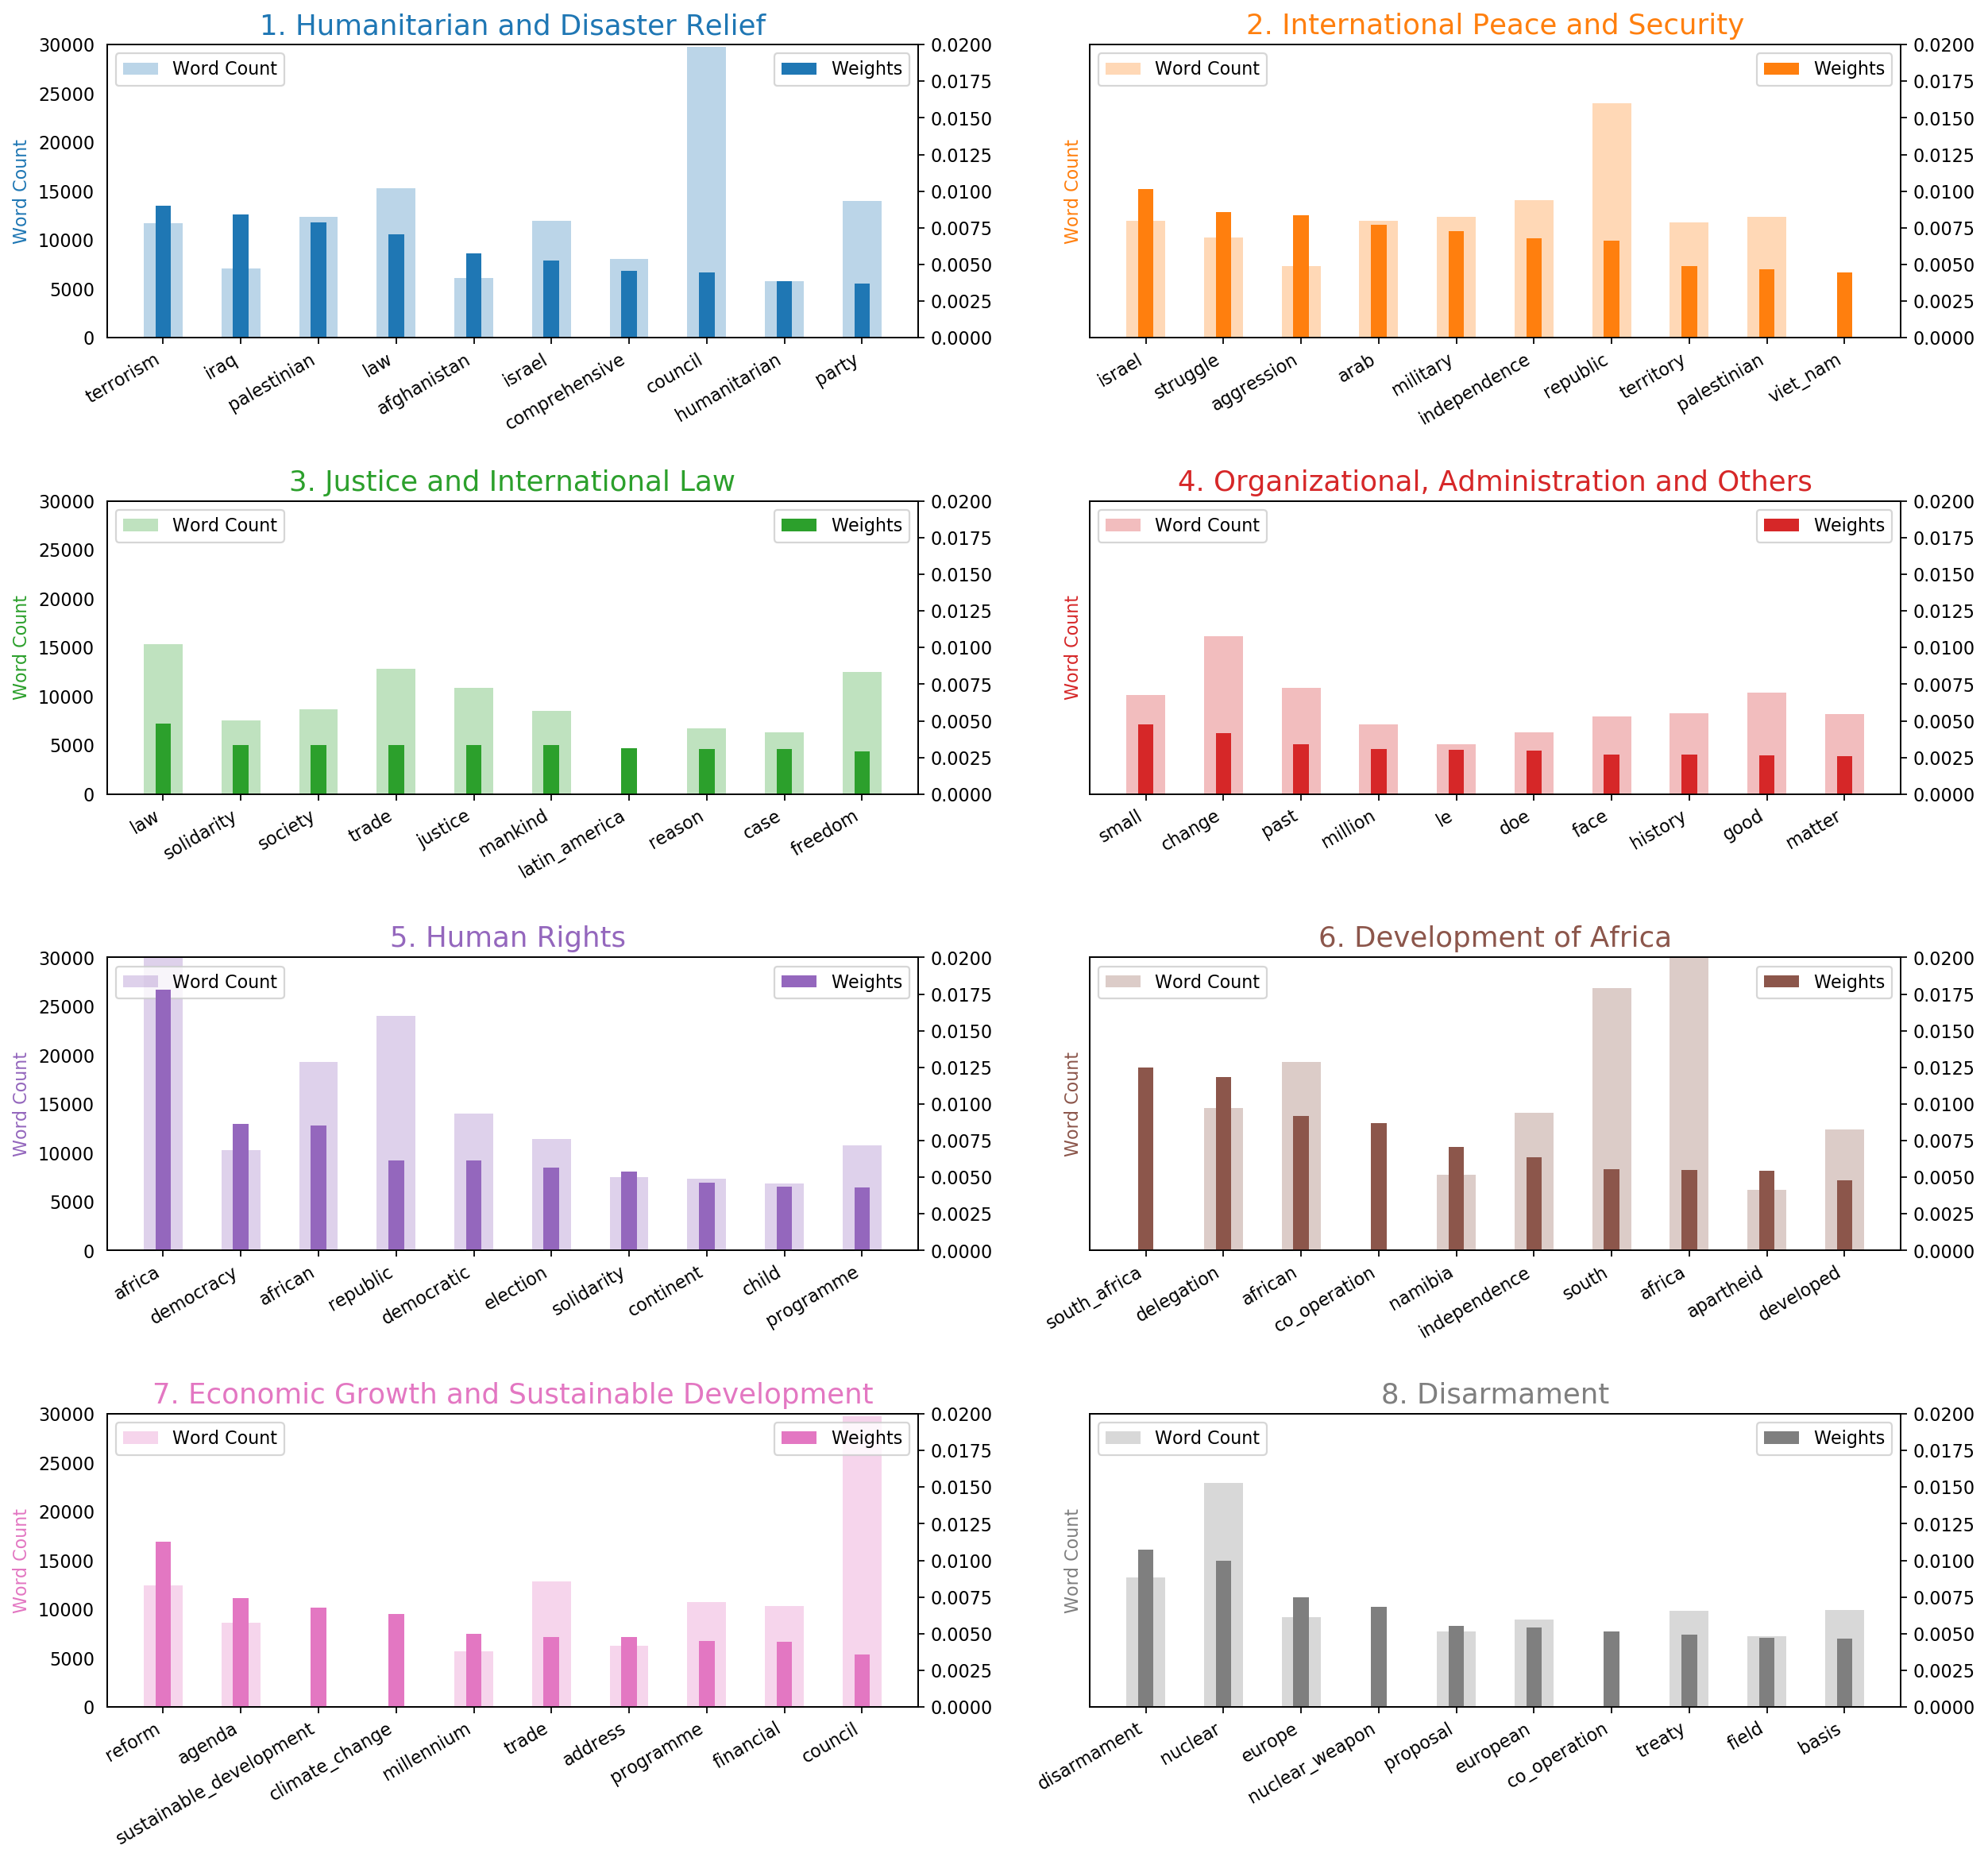

In [51]:
from collections import Counter
topics = lda_mallet.show_topics(formatted=False)
data_flat = [w for w_list in norm_words for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 2, figsize=(16,15), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    name = topic_names[i]
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.020); ax.set_ylim(0, 30000)
    ax.set_title('{}'.format(name), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')
    
fig.tight_layout(pad=2.0)   

In [ ]:
#Countries and their topics over the years 2006 - 2016